In [1035]:
#pip install transformers

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import random
import torch
import tensorflow_hub as hub
import tensorflow_text as text
from matplotlib import pyplot
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from sklearn.naive_bayes import GaussianNB


In [1023]:
#Load in both excel sheets (one labelled AM one labelled PM)

##

path_st = #insert path to StockTwits Data Collection.xlsx here, downloaded from the web-scraper
path_ind = #insert path to Stock Index Historical Data.xlsx here

def split_stdf(path_st):
    df_am = pd.read_excel(path_st, sheet_name = 'AM', index_col = None)
    df_pm = pd.read_excel(path_st, sheet_name = 'PM', index_col = None)
    
    return print(df_am.head()), print(df_pm.head())

def create_tod(df_am,df_pm):
    #create new "time of day" column
    df_am['time of day']='AM'
    df_pm['time of day']='PM'

    #combine both dataframes into one dataframe : 'df'
    df = df_am.append(df_pm)
    df = df.sort_values('Date')

    #convert text column into dtype string
    df = df.astype({'Text' : str})
    
    return print(df.head())
                                

In [1025]:
#number of unique dates
df['Date'].nunique()

18

In [1026]:
#number of NA values
print(df.isna().sum())

Date               0
Tag            18135
Text               0
Ticker            37
time of day        0
dtype: int64


In [1027]:
#create a seperate dataset with the non-NA values

df['Tag'].unique()
df['Tag'].value_counts()


Bullish        21618
Bearish         4665
Plus             135
Lifetime          27
PlusBullish       13
Name: Tag, dtype: int64

In [1029]:
#create dataframe for rows without a label, aka 'tag'
def notag_df(df):
    df_na = df[df['Tag'].isna()]
    df_na = df_na.dropna(subset= ['Text'])
    
    return print(df_na.head())

#create dataframe for prediction (text without labels)
def nolab_df(df_na):
    df_pred = df_na['Text']
    df_pred = df_pred.dropna()
    df_pred = df_pred.astype(str)
    
    return print(df_pred.head())



22296                                                  nan
22177    would say $130 is probably where this heads gi...
22178    They have been getting hammered cause of the c...
22179    Airbnb  Edges Higher Following an Upgrade to '...
22180    might be time for the mute button. The most vo...
                               ...                        
627                                                      🚀
628                                        Dead cat bounce
633                                welcome mew bag holders
637                                HERE WE GO LFG!!!! Yeah
639                                                    🚀🚀🚀
Name: Text, Length: 18135, dtype: object

In [1030]:
#load PorterStemmer and apply to df_pred
ps = PorterStemmer()
df_pred = df_pred.apply(ps.stem)

#load tokenizer and apply to df_pred
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
df_token = pd.DataFrame(df_pred.apply(tokenizer.tokenize))

In [1031]:
#create sample dataframe with all labeled data only
df_sample = df.dropna()
#drop columns with disambiguous tags
df_sample = df_sample.drop(df_sample[ (df_sample['Tag'] == 'Plus')].index)
df_sample = df_sample.drop(df_sample[ (df_sample['Tag'] == 'Lifetime')].index)
df_sample = df_sample.drop(df_sample[ (df_sample['Tag'] == 'PlusBullish')].index)


In [1033]:
#load label encoder
label_encoder = preprocessing.LabelEncoder()

#create a column 'label' that creates a label '0' or '1' depending on the tag 'Bearish' or 'Bullish'

def encode(df_sample):
    df_encode = df_sample.copy()
    df_encode['label']= label_encoder.fit_transform(df_sample['Tag'])
    df_encode = df_encode.drop(['Tag'], axis=1)

    return df_encode

,Date,Text,Ticker,time of day,label
22182,2021-08-03,God Andy sucks. Please let Michael talk.,$CRSR,AM,1
22186,2021-08-03,Welcome! Why is this pumping? I'm I too late?\...,$VGX.X,AM,1
22187,2021-08-03,where is Warren Buffett at ?? 3 G could ...,$CLX,AM,1
22190,2021-08-03,I sold my 23k coins so another voyager could r...,$VGX.X,AM,1
22200,2021-08-03,shorts and derampers now want to hear from Cra...,$DLPN,AM,1
...,...,...,...,...,...
638,2021-08-27,SHALL WE RUN IT BACK TO 50$?👀🤔,$SPRT,PM,1
640,2021-08-27,for all the dumb bears who Don’t do math the w...,$LCID,PM,1
641,2021-08-27,BUY THIS DIP UP!,$SPRT,PM,1
619,2021-08-27,holding until they cover.,$SPRT,PM,1


In [439]:
#create seperate dataframe for only labels and text
df_label = df_encode.drop(['Date','Ticker','time of day'], axis=1)
df_label['Text'] = df_label['Text'].astype(str)

#tokenize the text in df_label

def tokenize(df_label):
    df_token = df_label.copy()
    df_token['Text'] = pd.DataFrame(df_token['Text'].apply(tokenizer.tokenize))
    
    return df_token


,Text
22182,"[god, andy, sucks, ., please, let, michael, ta..."
22186,"[welcome, !, why, is, this, pumping, ?, i, ', ..."
22187,"[where, is, warren, buffet, ##t, at, ?, ?, 3, ..."
22190,"[i, sold, my, 23, ##k, coins, so, another, voy..."
22200,"[shorts, and, der, ##amp, ##ers, now, want, to..."
22202,"[enters, bear, ##ish, trend]"
22206,"[if, you, ’, re, not, shi, ##lling, other, boa..."
22175,"[kidd, ##os, buying, hard, here, —, let, them,..."
22173,"[wen, ##42, ##0, ?]"
22144,"[last, leg, before, the, crash]"


In [1034]:
#divide sample dataset into training and testing set
df_label.sample(frac = 0.3)
df_label['Text'] = df_label['Text'].astype(str)

train, test = train_test_split(df_label, test_size = 0.3)

In [11]:
#BEGIN BERT ANALYSIS


In [ ]:
#work cited for BERT code parameters: codebasics. 2021. Text Classification Using BERT & Tensorflow | Deep Learning Tutorial 47 (Tensorflow, Keras & Python). August 28. Accessed September 01, 2021. https://www.youtube.com/watch?v=hOCDJyZ6quA&ab_channel=codebasics

In [13]:
#load bert preprocessor to convert text into tensor data
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#load bert encoder for BERT model
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

INFO:absl:Using /var/folders/rh/7qgszsys60g7vrfhk4l__gsw0000gn/T/tfhub_modules to cache modules.


In [146]:
#balance dataset so that each label has same number of sample rows

def balance_df (df_label):
    df_label_bull = df_label[df_label['label'] == 1]
    df_label_bear = df_label[df_label['label'] == 0]
    df_label_bull_samp = df_label_bull.sample(df_label_bear.shape[0])

    df_label_bal = pd.concat([df_label_bear,df_label_bull_samp])
    
    return print(df_label_bal['label'].value_counts())

1    4656
0    4656
Name: label, dtype: int64

In [147]:
#split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(df_label_bal['Text'], df_label_bal['label'], stratify=df_label_bal['label'])


In [148]:
#load text data
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'text')
processed_text = bert_preprocess(text_input)
out = bert_encoder(processed_text)

#define BERT layer parameters
layer = tf.keras.layers.Dropout(0.1, name="dropout")(out['pooled_output'])
layer = tf.keras.layers.Dense(1, activation="sigmoid", name='output')(layer)

#define model
model = tf.keras.Model(inputs=[text_input], outputs=[layer])

In [149]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[13][0]               
                                                                 keras_layer[13][1]               
                                                                 keras_layer[13][2]               
____________________________________________________________________________________________

In [150]:
#define metrics to assess model performance

get_metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]


model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = get_metrics)

In [151]:
## WARNING: TRAINING MODEL WILL TAKE A LONG TIME: APPROX 5 - 10hr 

#train the model on the training data
#number of epochs reduced to 3 due to processing time
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
219/219 [==============================] - 1142s 5s/step - loss: 0.7163 - accuracy: 0.5093 - precision: 0.5096 - recall: 0.4928
Epoch 2/3
219/219 [==============================] - 1128s 5s/step - loss: 0.6969 - accuracy: 0.5269 - precision: 0.5268 - recall: 0.5292
Epoch 3/3
219/219 [==============================] - 1173s 5s/step - loss: 0.6923 - accuracy: 0.5438 - precision: 0.5446 - recall: 0.5352


In [193]:
export_dir='/Users/jameswarren/Desktop/Final Project Bert'
tf.saved_model.save(model, export_dir=export_dir)

INFO:tensorflow:Assets written to: /Users/jameswarren/Desktop/Final Project Bert/assets


INFO:tensorflow:Assets written to: /Users/jameswarren/Desktop/Final Project Bert/assets


In [152]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 364s 5s/step - loss: 0.6689 - accuracy: 0.6065 - precision: 0.6462 - recall: 0.4708


[0.6688897013664246,
 0.6065292358398438,
 0.6462264060974121,
 0.47079038619995117]

In [153]:
#use trained model to generate predictions on testing data
y_pred = model.predict(X_test)

In [154]:
#want to predict either label 1 or 0, values in between are insignificant
#any value above 0.5 is labelled 1, below is labeled 0
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)
np.unique(y_pred, return_counts = True)

(array([0, 1]), array([1480,  848]))

In [164]:
#model performance metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      1164
           1       0.65      0.47      0.54      1164

    accuracy                           0.61      2328
   macro avg       0.62      0.61      0.60      2328
weighted avg       0.62      0.61      0.60      2328



In [158]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

array([[864, 300],
       [616, 548]])

Text(33.0, 0.5, 'true value')

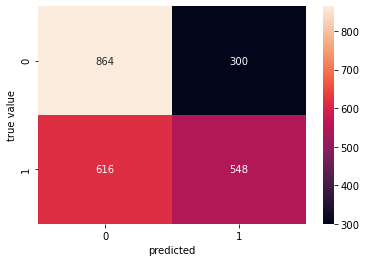

In [163]:
#confusion matrix heatmap 

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('true value')


In [320]:
print(df_pred.shape)

(18135,)

In [180]:
#apply trained bert model on rest of dataset

tag_pred = model.predict(df_pred)
tag_pred = tag_pred.flatten()
tag_pred = np.where(tag_pred > 0.5, 1, 0)
print(np.unique(tag_pred, return_counts = True))


(array([0, 1]), array([10814,  7321]))

In [321]:
#save so not to have to generate predictions again
prediction_saved = pd.DataFrame(tag_pred).to_csv('prediction.csv')

#assign column on data without labels using predicted labels
df_na['label'] = tag_pred

#switch order of columns
pred = pred[pred.columns[::-1]]

#combine both dataframe to form one large dataframe
df_merged = pd.concat([df_na, df_encode])
df_merged.shape
print("Unique:",df_merged['Date'].nunique())

#Group by date and time of day
df_bert_grouped = df_merged.groupby([(pd.Grouper(key='Date', axis=0, 
                      freq='D')), 'time of day']).mean()



(18135,)

In [423]:
#plot bert sentiment trend
df_bert_grouped.plot(subplots=True, legend=False)
plt.title("BERT Model Predicted Sentiment Trend")
pyplot.show()

(44313, 6)

18

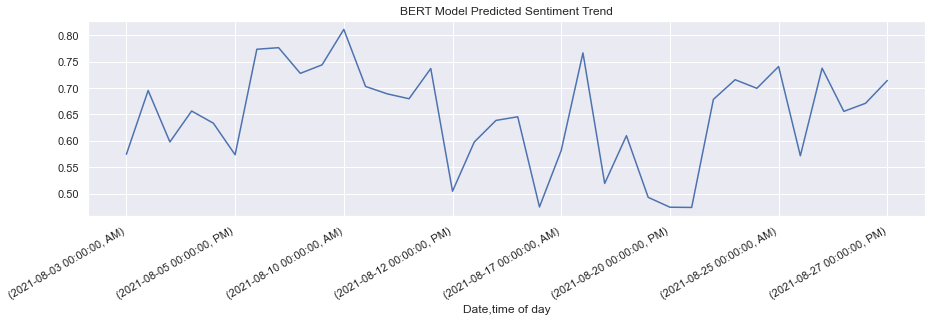

In [ ]:
#BEGIN VADER ANALYSIS

In [ ]:
#work cited for VADER parameters: Beri, Aditya. 2020. Towards Data Science. May 27. Accessed September 08, 2021. https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664.

In [464]:
#load vader lexicon
nltk.download('vader_lexicon')
#load vader sentiment analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jameswarren/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [466]:
#assign column "sentiment" to store polarity scores for each row of text data
df_sample['Sentiment'] = df_sample['Text'].apply(lambda text: sid.polarity_scores(text))
df_sample

,Date,Tag,Text,Ticker,time of day,Sentiment
22182,2021-08-03,Bullish,God Andy sucks. Please let Michael talk.,$CRSR,AM,"{'neg': 0.229, 'neu': 0.367, 'pos': 0.404, 'co..."
22186,2021-08-03,Bullish,Welcome! Why is this pumping? I'm I too late?\...,$VGX.X,AM,"{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'comp..."
22187,2021-08-03,Bullish,where is Warren Buffett at ?? 3 G could ...,$CLX,AM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
22190,2021-08-03,Bullish,I sold my 23k coins so another voyager could r...,$VGX.X,AM,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp..."
22200,2021-08-03,Bullish,shorts and derampers now want to hear from Cra...,$DLPN,AM,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp..."
...,...,...,...,...,...,...
638,2021-08-27,Bullish,SHALL WE RUN IT BACK TO 50$?👀🤔,$SPRT,PM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
640,2021-08-27,Bullish,for all the dumb bears who Don’t do math the w...,$LCID,PM,"{'neg': 0.09, 'neu': 0.789, 'pos': 0.12, 'comp..."
641,2021-08-27,Bullish,BUY THIS DIP UP!,$SPRT,PM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
619,2021-08-27,Bullish,holding until they cover.,$SPRT,PM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [467]:
#create new column 'compound' to store only compound scores
df_sample['compound']  = df_sample['Sentiment'].apply(lambda score_dict: score_dict['compound'])

#assign tag based on compound score
df_sample['pred_tag'] = df_sample['compound'].apply(lambda c: 'Bullish' if c >=0 else 'Bearish' )

df_sample.head()

In [469]:
#create accuracy score using the actual tag and predicted tag using VADER compound score
accuracy = sklearn.metrics.accuracy_score(df_sample['Tag'], df_sample['pred_tag'], normalize=True, sample_weight=None)
print(accuracy)

In [470]:
print(df_sample['pred_tag'].value_counts())

0.7335166934066774

In [473]:
#plot distribution of compound scores
plt.hist(df_sample['compound'], bins=20)

Bullish    21254
Bearish     4924
Name: pred_tag, dtype: int64

(array([  124.,   323.,   389.,   582.,   754.,   745.,   889.,   470.,
          424., 12762.,   411.,   402.,   787.,  1307.,  1484.,  1276.,
         1166.,   863.,   710.,   310.]),
 array([-0.9807  , -0.881845, -0.78299 , -0.684135, -0.58528 , -0.486425,
        -0.38757 , -0.288715, -0.18986 , -0.091005,  0.00785 ,  0.106705,
         0.20556 ,  0.304415,  0.40327 ,  0.502125,  0.60098 ,  0.699835,
         0.79869 ,  0.897545,  0.9964  ]),
 <BarContainer object of 20 artists>)

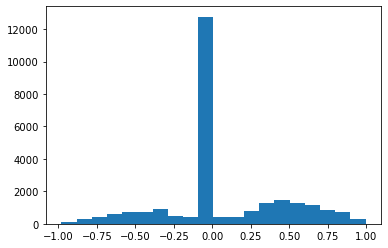

In [475]:
#extend params so that now there are less zeros
df_sample['pred_tag'] = df_sample['compound'].apply(lambda c: 'Bullish' if c >=0.2 else ('Bearish' if c<=-0.2 else ("indistinguishable")))

#drop all rows with indistinguishable label
print(df_sample['pred_tag'].value_counts())
df_sig_pred = df_sample.drop(df_sample[df_sample['pred_tag']== 'indistinguishable'].index)
df_sig_pred

In [477]:
#calculate new accuracy score
accuracy_sig_pred = sklearn.metrics.accuracy_score(df_sig_pred['Tag'], df_sig_pred['pred_tag'], normalize=True, sample_weight=None)
print(accuracy_sig_pred)

0.6559050445103858

In [479]:
#drop rows with empty text
empty_values = df[(df['Text'] == 'nan') & (df['Text'].isna())].index
df_new = df.drop(empty_values)

#apply VADER model to all data
df_new['Sentiment'] = df_new['Text'].apply(lambda text: sid.polarity_scores(text))
df_new['compound']  = df_new['Sentiment'].apply(lambda score_dict: score_dict['compound'])
print(df_new.head())

,Date,Tag,Text,Ticker,time of day,Sentiment,compound
22296,2021-08-03,NaN,nan,$CRBTF,AM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
22177,2021-08-03,NaN,would say $130 is probably where this heads gi...,$CLX,AM,"{'neg': 0.0, 'neu': 0.922, 'pos': 0.078, 'comp...",0.5267
22178,2021-08-03,NaN,They have been getting hammered cause of the c...,$CRSR,AM,"{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'comp...",-0.2500
22179,2021-08-03,NaN,Airbnb Edges Higher Following an Upgrade to '...,$ABNB,AM,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
22180,2021-08-03,NaN,might be time for the mute button. The most vo...,$CRSR,AM,"{'neg': 0.049, 'neu': 0.889, 'pos': 0.062, 'co...",0.1280


In [583]:
#group by date and time of day
df_vader_grouped = df_new.groupby(['Date', 'time of day']).mean()
print(df_vader_grouped)

#drop all rows with compound score = 0
empty_comp = df_new[(df_new['compound'] == 0.0000)].index
df_c = df_new.drop(empty_comp)

#group by date and time of day
df_cgrouped = df_c.groupby(['Date', 'time of day']).mean()
print(df_cgrouped)

                        compound
Date       time of day          
2021-08-03 AM           0.085206
           PM           0.105309
2021-08-04 AM           0.063167
           PM           0.042805
2021-08-05 AM           0.097504
           PM           0.081889
2021-08-06 AM           0.112204
           PM           0.077652
2021-08-09 AM           0.113158
           PM           0.142065
2021-08-10 AM           0.074589
           PM           0.097754
2021-08-11 AM           0.077521
           PM           0.092634
2021-08-12 AM           0.117178
           PM           0.039002
2021-08-13 AM           0.085363
           PM           0.020652
2021-08-16 AM           0.120927
           PM           0.033580
2021-08-17 AM           0.086745
           PM           0.136606
2021-08-19 AM           0.051466
           PM           0.062363
2021-08-20 AM           0.042074
           PM           0.043101
2021-08-23 AM           0.043101
           PM           0.075005
2021-08-24

(array([  70.,  137.,  235.,  220.,  314.,  429.,  632.,  478.,  479.,
         417.,  708.,  370.,  295.,  273.,  178.,  153.,  371.,  332.,
         288.,  707., 1054., 1070.,  778.,  771.,  732.,  620.,  454.,
         417.,  383.,  130.]),
 array([-0.9807    , -0.91479667, -0.84889333, -0.78299   , -0.71708667,
        -0.65118333, -0.58528   , -0.51937667, -0.45347333, -0.38757   ,
        -0.32166667, -0.25576333, -0.18986   , -0.12395667, -0.05805333,
         0.00785   ,  0.07375333,  0.13965667,  0.20556   ,  0.27146333,
         0.33736667,  0.40327   ,  0.46917333,  0.53507667,  0.60098   ,
         0.66688333,  0.73278667,  0.79869   ,  0.86459333,  0.93049667,
         0.9964    ]),
 <BarContainer object of 30 artists>)

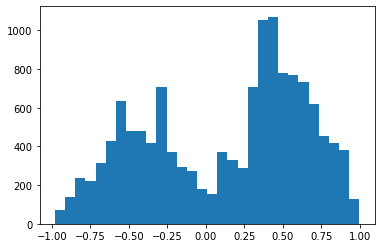

In [482]:
#plot new distribution without 0 values
plt.hist(df_c['compound'], bins=30)


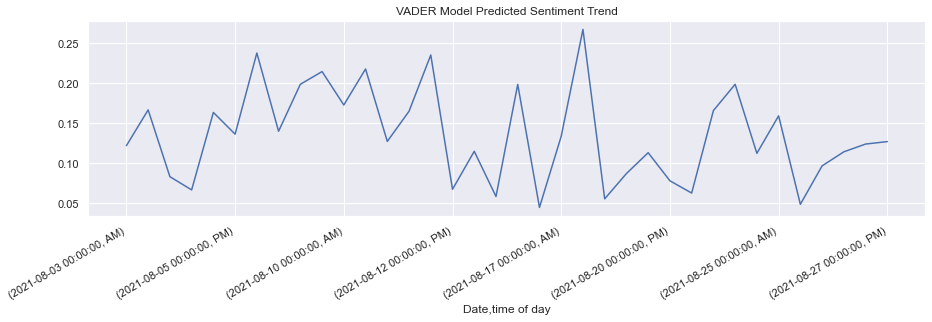

In [1007]:
#plot sentiment trend as found by VADER model
df_cgrouped.plot(subplots=True, legend=False)
plt.title("VADER Model Predicted Sentiment Trend")
pyplot.show()

In [591]:
#load stock index data
#make sure path_ind from top of workbook is entered (path to excel sheet with stock index data)
df_dow = pd.read_excel(path_ind, sheet_name = 'Dow', index_col = None)
df_sandp = pd.read_excel(path_ind, sheet_name = 'S&P 500', index_col = None)
df_nasdaq = pd.read_excel(path_ind, sheet_name = 'Nasdaq', index_col = None)

#group by date and time of day
df_dow_g = df_dow.groupby(['Date','Time of Day']).mean()
df_sandp_g = df_sandp.groupby(['Date','Time of Day']).mean()
df_nasdaq_g = df_nasdaq.groupby(['Date','Time of Day']).mean()

print(df_dow_g)

#plot dow grouped data to visualize
df_dow_g.plot()
pyplot.show()

In [712]:
#scale all data using min-max scaling so that all values fall between 0 and 1 

scaler = MinMaxScaler()
vader_scaled = pd.DataFrame(scaler.fit_transform(df_cgrouped),columns = ['vader'])
bert_scaled = pd.DataFrame(scaler.fit_transform(df_bert_grouped), columns = ['bert'])
dow_scaled = pd.DataFrame(scaler.fit_transform(df_dow_g), columns = ['dow'])
sandp_scaled = pd.DataFrame(scaler.fit_transform(df_sandp_g),columns = ['SandP'])
nasdaq_scaled = pd.DataFrame(scaler.fit_transform(df_nasdaq_g), columns = ['nasdaq'])

In [629]:
#create seperate dataframes containing index data, sentiment models data, and all data
df_indecies = pd.concat([dow_scaled, sandp_scaled, nasdaq_scaled], axis = 1)
df_sntmt = pd.concat([vader_scaled,bert_scaled], axis = 1)
df_metric = pd.concat([vader_scaled,bert_scaled, dow_scaled, sandp_scaled, nasdaq_scaled], axis = 1)

In [611]:

#compare trends

Text(0.5, 1.0, 'Index Trend Comparison: 3 Aug - 27 Aug')

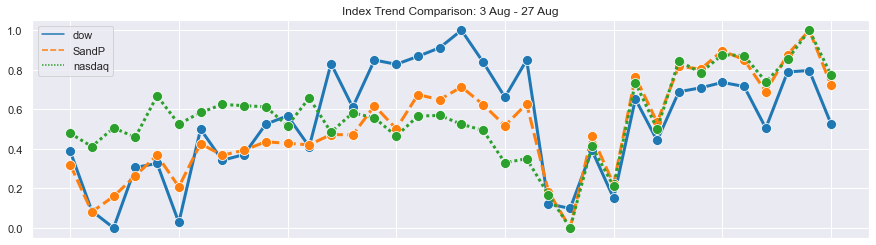

In [1012]:
#plot index data
sns.set(rc={'figure.figsize':(15, 4)})
ind_plt = sns.lineplot(data=df_indecies, linewidth = 3, marker='o', markersize=10, linestyle='-', palette= 'tab10')
ind_plt.set(xticklabels=[])
ind_plt.set_title('Index Trend Comparison: 3 Aug - 27 Aug')


Text(0.5, 1.0, 'BERT & VADER Model Sentiment Trend Comparison: 3 Aug - 27 Aug')

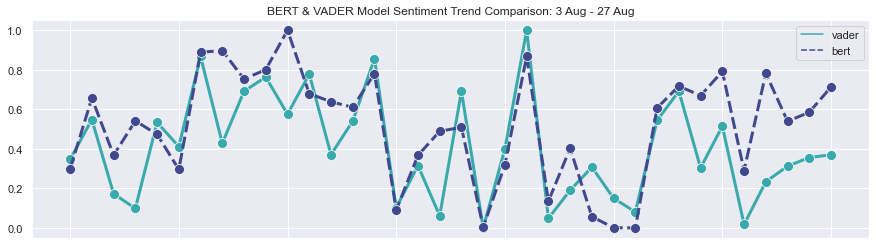

In [1015]:
#plot both sentiment models
snt_plt = sns.lineplot(data=df_sntmt, linewidth = 3, marker='o', markersize=10, linestyle='-', palette = "mako_r")
snt_plt.set(xticklabels=[])
snt_plt.set_title('BERT & VADER Model Sentiment Trend Comparison: 3 Aug - 27 Aug')


In [713]:
#define a function that applies mean squared error

def find_mse(predicted, real):
    mse = mean_squared_error(predicted, real)
    return mse

#calculate MSE for all combinations of VADER and BERT models with indices
vader_dow_mse = find_mse(vader_scaled, dow_scaled)
vader_sandp_mse = find_mse(vader_scaled, sandp_scaled)
vader_nasdaq_mse = find_mse(vader_scaled, nasdaq_scaled)
bert_dow_mse = find_mse(bert_scaled, dow_scaled)
bert_sandp_mse = find_mse(bert_scaled, sandp_scaled)
bert_nasdaq_mse = find_mse(bert_scaled, nasdaq_scaled)

print("The MSE for VADER Predictions on Dow data is:", vader_dow_mse)
print("The MSE for VADER Predictions on S&P data is:", vader_sandp_mse)
print("The MSE for VADER Predictions on Nasdaq data is:", vader_sandp_mse)
print("The MSE for BERT Predictions on Dow data is:", bert_dow_mse)
print("The MSE for BERT Predictions on S&P data is:", bert_sandp_mse)
print("The MSE for BERT Predictions on Nasdaq data is:", bert_nasdaq_mse)

The MSE for VADER Predictions on Dow data is: 0.14315467175600335
The MSE for VADER Predictions on S&P data is: 0.1342149749264191
The MSE for VADER Predictions on Nasdaq data is: 0.1342149749264191
The MSE for BERT Predictions on Dow data is: 0.13100818243097476
The MSE for BERT Predictions on S&P data is: 0.11468932046214673
The MSE for BERT Predictions on Nasdaq data is: 0.0824833963501478


Text(0.5, 1.0, 'BERT & Nasdaq Trend Comparison: 3 Aug - 27 Aug')

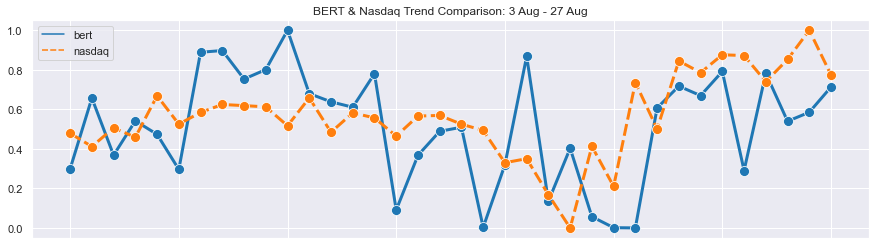

In [1016]:
#create dataframe for both BERT and Nasdaq data
bert_nasdaq_df = pd.concat([bert_scaled, nasdaq_scaled], axis = 1)

#plot
snt_plt = sns.lineplot(data=bert_nasdaq_df, linewidth = 3, marker='o', markersize=10, linestyle='-', palette = 'tab10')
snt_plt.set(xticklabels=[])

snt_plt.set_title('BERT & Nasdaq Trend Comparison: 3 Aug - 27 Aug')


In [978]:
#shift index data forward by one period and drop the last row

dow_shift = dow_scaled.shift(-1)
dow_shift = dow_shift.dropna()
sandp_shift = sandp_scaled.shift(-1)
sandp_shift = sandp_shift.dropna()
nasdaq_shift = nasdaq_scaled.shift(-1)
nasdaq_shift = nasdaq_shift.dropna()

vader_shift = vader_scaled.head(vader_scaled.shape[0] -1)
bert_shift = bert_scaled.head(bert_scaled.shape[0] -1)


In [979]:
#calculate new MSEs
vader_dow_mse_s = find_mse(vader_shift, dow_shift)
vader_sandp_mse_s = find_mse(vader_shift, sandp_shift)
vader_nasdaq_mse_s = find_mse(vader_shift, nasdaq_shift)
bert_dow_mse_s = find_mse(bert_shift, dow_shift)
bert_sandp_mse_s = find_mse(bert_shift, sandp_shift)
bert_nasdaq_mse_s = find_mse(bert_shift, nasdaq_shift)

print("The MSE for VADER Predictions on Dow data is:", vader_dow_mse_s)
print("The MSE for VADER Predictions on S&P data is:", vader_sandp_mse_s)
print("The MSE for VADER Predictions on Nasdaq data is:", vader_sandp_mse_s)
print("The MSE for BERT Predictions on Dow data is:", bert_dow_mse_s)
print("The MSE for BERT Predictions on S&P data is:", bert_sandp_mse_s)
print("The MSE for BERT Predictions on Nasdaq data is:", bert_nasdaq_mse_s)

The MSE for VADER Predictions on Dow data is: 0.17129051810225596
The MSE for VADER Predictions on S&P data is: 0.16126966601646123
The MSE for VADER Predictions on Nasdaq data is: 0.16126966601646123
The MSE for BERT Predictions on Dow data is: 0.14803469654254817
The MSE for BERT Predictions on S&P data is: 0.1259474813982136
The MSE for BERT Predictions on Nasdaq data is: 0.08335444960882318


Text(0.5, 1.0, 'BERT & Nasdaq One period Forward Look Comparison')

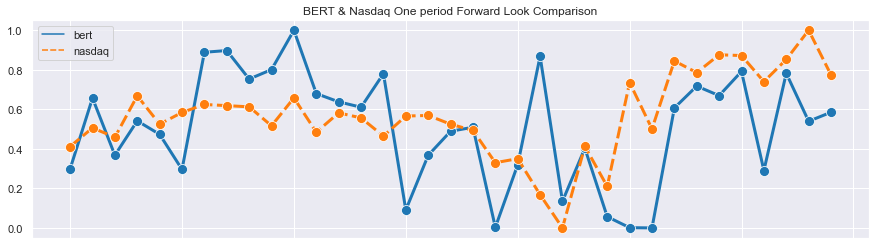

In [1018]:
#combine bert and nasdaq data
bert_nasdaq_df_s = pd.concat([bert_shift, nasdaq_shift], axis = 1)

#plot
snt_plt = sns.lineplot(data=bert_nasdaq_df_s, linewidth = 3, marker='o', markersize=10, linestyle='-', palette = 'tab10')
snt_plt.set(xticklabels=[])
snt_plt.set_title('BERT & Nasdaq One period Forward Look Comparison')


In [1019]:
#NAIVE BAYES

In [ ]:
nasdaq_diff = nasdaq_shift.diff()
bert_diff = bert_shift.diff()
bert_prediction = bert_diff.dropna()

In [982]:
#define functions to assign labels of -1,0,1 for the ranges of sentiment

def find_nas_trend(nasdaq_diff):
    
    conditions = [
        (nasdaq_diff['nasdaq'] <= -0.2),
        (nasdaq_diff['nasdaq'] >= 0.2),
        (nasdaq_diff['nasdaq'] < 0.2) & (nasdaq_diff['nasdaq'] > -0.2)
        ]
    values = ['-1', '1', '0']
    nasdaq_diff['trend'] = np.select(conditions, values)
    nasdaq_diff_drop = nasdaq_diff.dropna()
    
    return nasdaq_diff_drop

def find_bert_trend(bert_diff):
    
    conditions = [
        (bert_diff['bert'] <= -0.2),
        (bert_diff['bert'] >= 0.2),
        (bert_diff['bert'] < 0.2) & (bert_diff['bert'] > -0.2)
        ]
    values = ['-1', '1', '0']
    bert_diff['trend'] = np.select(conditions, values)
    bert_diff_drop = bert_diff.dropna()
    
    return bert_diff_drop

In [983]:
#run functions above and assign to variables
nasdaq_df = find_nas_trend(nasdaq_diff)
bert_df = find_bert_trend(bert_diff)

In [984]:
nasdaq_df['trend']

1      0
2      0
3      1
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     1
24    -1
25     1
26    -1
27     1
28     0
29     0
30     0
31     0
32     0
33     0
34    -1
Name: trend, dtype: object

In [1]:
#assign variables and split into training and testing sets
X_ = pd.DataFrame(nasdaq_df['nasdaq'])
y_ = np.array(nasdaq_df['trend'])
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.30)

#only 11 samples for testing data
print(X_test_.shape)

NameError: name 'pd' is not defined

In [987]:
#load Gaussian Naive Bayes model
classifier = GaussianNB()

#train the Gaussian Naive Bayes model using the training data and labels
classifier.fit(X_train_, y_train_)

GaussianNB()

In [988]:
#generate predictions on test data

y_pred_  =  classifier.predict(X_test_)

#generate confusion matrix and accuracy score
cm_ = confusion_matrix(y_test_, y_pred_)
ac_ = accuracy_score(y_test_,y_pred_)

print(cm_)
print(ac_)


In [992]:
#generate classifications on entire dataset 
bert_pred = pd.DataFrame(classifier.predict(bert_prediction))

#generate final accuracy score on real nasdaq trend labels
bert_nas_acc = accuracy_score(nasdaq_df['trend'],bert_pred)

print(bert_nas_acc)